# Import data

In [37]:
from Utils.Toolkit import TestGen, DataReader
from Utils.Toolkit import TestSplit
import numpy as np

dataReader = DataReader()

# Very high sparsity

In [84]:
URM = DataReader().URM_COO()
sparsity = URM.getnnz() / (URM.shape[0] * URM.shape[1])
sparsity

0.0006972830778968816

# Cold users

In [39]:
URM = URM.tocsr()
cold_users_list = []

cold_users = 0
for i in range(len(URM.indptr)-1):
    if URM.indptr[i+1]-URM.indptr[i] == 0:
        cold_users_list.append(i)
        cold_users += 1

print(f'Total users: {len(URM.indptr)}')
print(f'Cold users: {cold_users}')
print(f'Percentage of cold users: {cold_users/len(URM.indptr)*100:.2f}%\t ')
print(f'First 10 cold users: {cold_users_list[:10]}')

Total users: 30912
Cold users: 3656
Percentage of cold users: 11.83%	 
First 10 cold users: [20, 23, 24, 26, 41, 42, 46, 48, 67, 68]


# Cold items

In [40]:
URM = URM.tocsc()
cold_items_list = []

cold_users = 0
for i in range(len(URM.indptr)-1):
    if URM.indptr[i+1]-URM.indptr[i] == 0:
        cold_items_list.append(i)
        cold_users += 1

print(f'Total items: {len(URM.indptr)}')
print(f'Cold items: {cold_users}')
print(f'Percentage of cold items: {cold_users/len(URM.indptr)*100:.2f}%')
print(f'First 10 cold items: {cold_items_list[:10]}')

Total items: 18496
Cold items: 3218
Percentage of cold items: 17.40%
First 10 cold items: [1, 3, 8, 14, 15, 16, 24, 26, 27, 31]


# Cold users in our target

In [41]:
numer_of_cold_target_users = np.sum(np.isin(np.arange(URM.shape[0]), cold_users_list))
print(f'Number of cold users in target: {numer_of_cold_target_users}')
print(f'Percentage: {numer_of_cold_target_users/URM.shape[0]*100:.2f}%')

Number of cold users in target: 3656
Percentage: 11.83%


# See users with K interactions

In [63]:
users_rated = np.zeros((URM.shape[1],), dtype=int)

URM = URM.tocsr()

for i in range(len(URM.indptr)-1):
    num_of_interaction_in_row = URM.indptr[i+1] - URM.indptr[i]
    users_rated[num_of_interaction_in_row] += 1

for i in range(10):
    if users_rated[i] != 0:
        print(f'{users_rated[i]} have {i} interactions')

3656 have 0 interactions
2817 have 1 interactions
1919 have 2 interactions
1776 have 3 interactions
1658 have 4 interactions
1469 have 5 interactions
1429 have 6 interactions
1230 have 7 interactions
1128 have 8 interactions
923 have 9 interactions


# Let's divide in bigger groups

In [82]:
first_groups = np.arange(0, 11, 5)
second_groups = np.arange(20, 100, 10)
groups = np.append(first_groups, second_groups)

for i in range(len(groups) - 1):
    print(f'{groups[i]:4} < i < {groups[i+1]:3}: {np.sum(users_rated[groups[i]:groups[i+1]]):6} -> {np.sum(users_rated[groups[i]:groups[i+1]])/URM.shape[0]*100:.2f}%')

   0 < i <   5:  11826 -> 38.26%
   5 < i <  10:   6179 -> 19.99%
  10 < i <  20:   6377 -> 20.63%
  20 < i <  30:   2966 -> 9.60%
  30 < i <  40:   1512 -> 4.89%
  40 < i <  50:    839 -> 2.71%
  50 < i <  60:    487 -> 1.58%
  60 < i <  70:    262 -> 0.85%
  70 < i <  80:    155 -> 0.50%
  80 < i <  90:     93 -> 0.30%


# Plot some items stuff

<IPython.core.display.Javascript object>


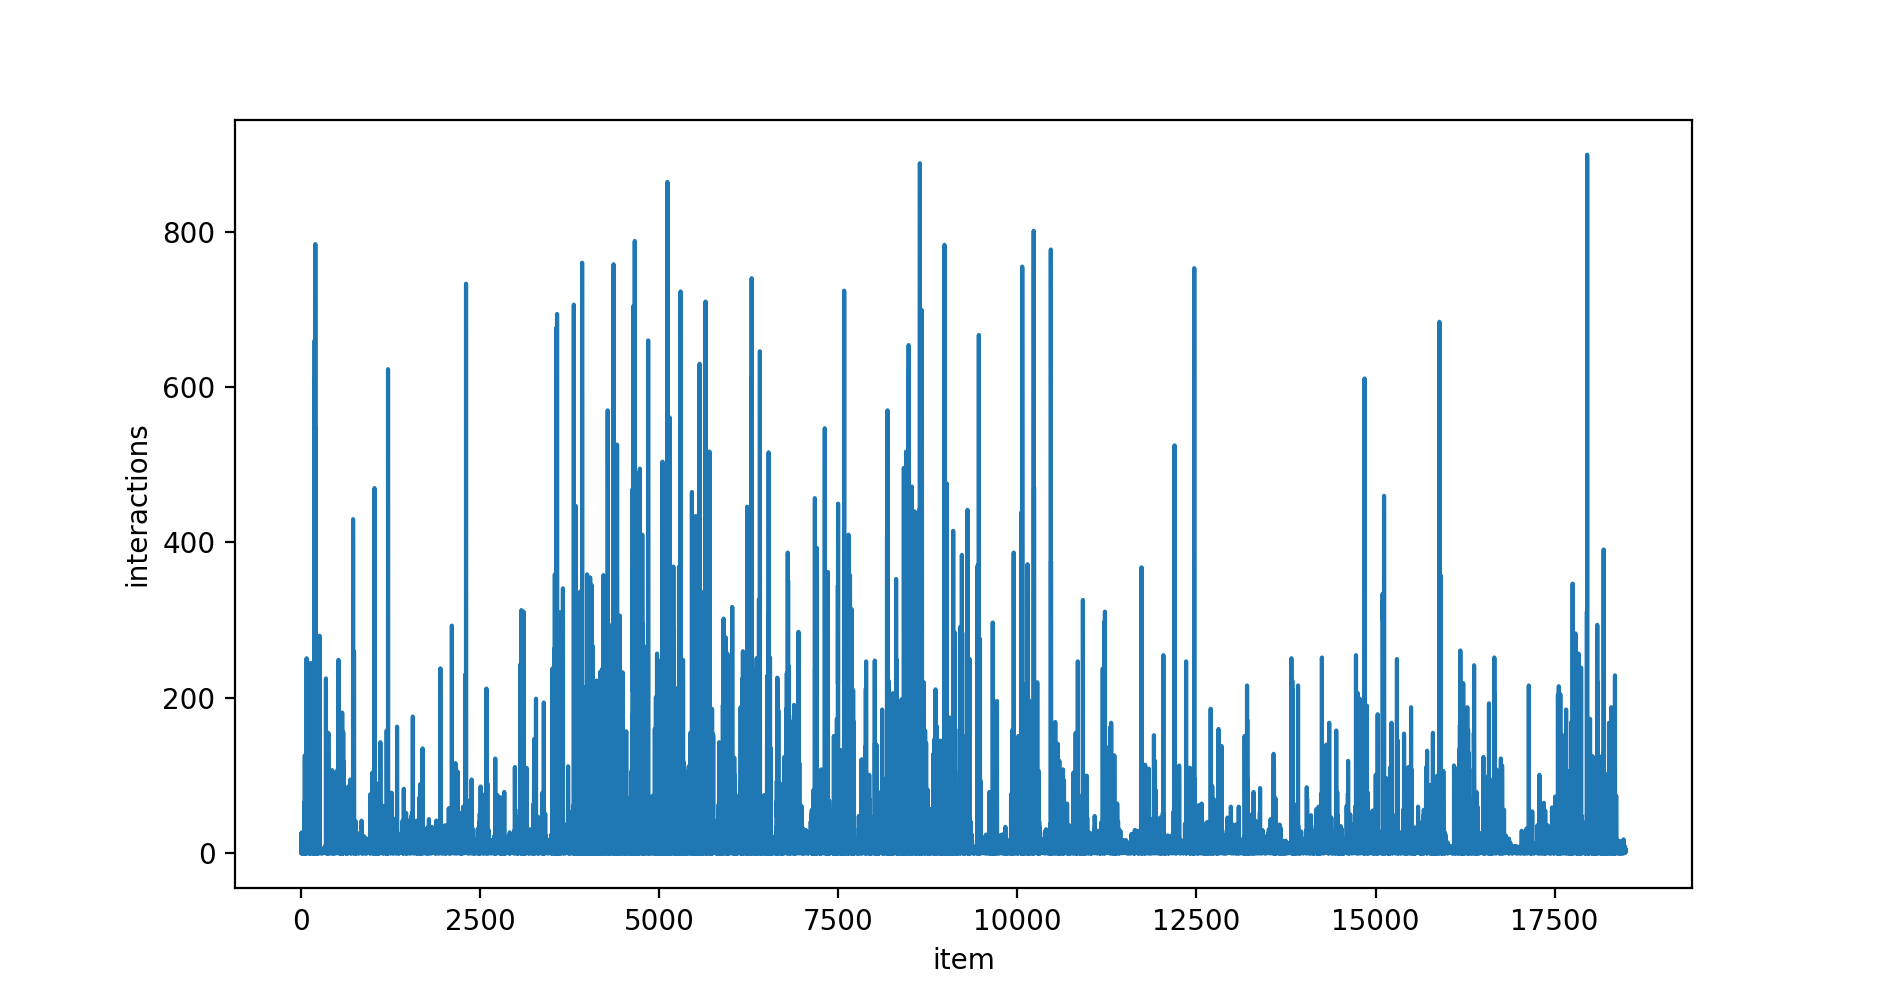

In [89]:
%matplotlib notebook
import matplotlib.pyplot as plt
y_axis = []
x_axis = np.arange(URM.shape[1])
URM = URM.tocsc()

for i in range(len(URM.indptr)-1):
    value = URM.indptr[i+1]-URM.indptr[i]
    y_axis.append(value)

plt.plot(x_axis, y_axis)
plt.xlabel('item')
plt.ylabel('interactions')
plt.show()

# Generate Test & Setup

In [23]:
k_fold = TestGen(dataReader.URM_CSR(), TestSplit.K_FOLD, k=3)
matrices = k_fold.get_k_fold_matrices()
target_users = dataReader.targetUsersList

# ItemCF K_Fold

In [24]:
from CF.item_cf import ItemBasedCollaborativeFiltering

for i in range(len(matrices)):
    test_matrix = matrices[i]
    train_matrix = None

    for j in range(len(matrices)):
            if j != i:
                if train_matrix is not None:
                    train_matrix += matrices[j]
                else:
                    train_matrix = matrices[j]

    itemCF1 = ItemBasedCollaborativeFiltering(train_matrix, topK=10, shrink=30)
    itemCF1.fit(similarity="tanimoto")
    itemCF1.evaluate_MAP_target(test_matrix, target_users)

UserCF -> MAP: 0.0428 with TopK = 10 & Shrink = 30	
UserCF -> MAP: 0.0427 with TopK = 10 & Shrink = 30	
UserCF -> MAP: 0.0426 with TopK = 10 & Shrink = 30	


# UserCF K_Fold

In [25]:
from CF.user_cf import UserBasedCollaborativeFiltering

for i in range(len(matrices)):
    test_matrix = matrices[i]
    train_matrix = None

    for j in range(len(matrices)):
            if j != i:
                if train_matrix is not None:
                    train_matrix += matrices[j]
                else:
                    train_matrix = matrices[j]

    userCF1 = UserBasedCollaborativeFiltering(train_matrix, topK=100, shrink=500)
    userCF1.fit()
    userCF1.evaluate_MAP_target(test_matrix, target_users)

UserCF -> MAP: 0.0334 with TopK = 100 & Shrink = 500	, elapsed time 0.30 min
UserCF -> MAP: 0.0324 with TopK = 100 & Shrink = 500	, elapsed time 0.30 min
UserCF -> MAP: 0.0336 with TopK = 100 & Shrink = 500	, elapsed time 0.32 min


# Hybrid K_Fold

In [26]:
from HYB.hybrid import HybridRecommender

for i in range(len(matrices)):
    test_matrix = matrices[i]
    train_matrix = None

    for j in range(len(matrices)):
            if j != i:
                if train_matrix is not None:
                    train_matrix += matrices[j]
                else:
                    train_matrix = matrices[j]

    hyb = HybridRecommender(train_matrix, userCF1, itemCF1)
    hyb.fit(1, 2)
    hyb.evaluate_MAP_target(test_matrix, target_users)

TypeError: __init__() takes 2 positional arguments but 4 were given